# 05 — Prescriptive Recommender System

**Amaç:** 04. notebook'ta eğitilen dürüst "Conversion Predictor" modelini kullanarak, her müşteri için **hangi Kampanya Kanalı + Platform** ikilisinin dönüşüm olasılığını en çok artıracağını öneren bir **Prescriptive (Reçeteleyici) Öneri Sistemi** kurmak.

**Akış:** 1) Varlık yükleme (model, scaler, imputer, test verisi) → 2) Strateji simülasyonu (`recommend_action`) → 3) Performans Lift analizi → 4) Segment–kanal heatmap ve feature importance ilişkisi.

## Predictive vs Prescriptive Analitik

- **Predictive (Tahmine dayalı):** "Ne olacak?" sorusuna cevap verir. Örneğin: Bu müşterinin mevcut kanal/platform ile dönüşüm yapma olasılığı nedir?
- **Prescriptive (Reçeteleyici):** "Ne yapmalıyız?" sorusuna cevap verir. Örneğin: Bu müşteriyi dönüştürmek için hangi kanal+platform kombinasyonunu kullanmalıyız?

Bu notebook'ta, aynı tahmin modelini **simülasyon** ile kullanıyoruz: Tüm olası aksiyonları (kanal+platform çiftleri) deneyip en yüksek dönüşüm olasılığını veren aksiyonu **öneri** olarak sunuyoruz. Yani model pasif bir tahminci olmaktan çıkıp **aktif bir strateji motoru**na dönüşüyor.

## Model Persistence: Neden .pkl Dosyaları?

04. notebook'ta eğitilen model, scaler ve imputer **disk üzerinde** `.pkl` (pickle) dosyaları olarak kaydedildi. Böylece:

1. **Yeniden eğitim gerekmez:** Aynı pipeline (özellik hazırlama → impute → scale → tahmin) başka bir ortamda (bu notebook, API, vb.) tekrarlanabilir.
2. **Versiyonlama:** Hangi modelin kullanıldığı nettir (`models/final_model.pkl`).
3. **Tutarlılık:** Scaler ve imputer, eğitim verisi üzerinde fit edildiği için test/öneri verisinde **aynı dönüşümler** uygulanmalıdır; bu dosyalar olmadan özellik uzayı uyumsuz kalır.

Bu notebook, `models/final_model.pkl`, `models/scaler.pkl` ve `models/imputer.pkl` dosyalarını yükleyerek 04. notebook ile **aynı** modeli kullanır.

## Klasik User-Based Collaborative Filtering'dan Farkı

- **User-Based CF:** "Senin gibi kullanıcılar şunu beğendi" der; benzer kullanıcıların geçmiş davranışına dayanır. Çıktı genelde **ürün/içerik önerisi** (rating/item).
- **Bu sistem:** Müşteri **profil özelliklerine** (yaş, gelir, geçmiş alışveriş vb.) ve **alabileceğimiz aksiyona** (hangi kanal+platform) bakarak, **dönüşüm olasılığını maksimize eden aksiyonu** önerir. Yani **aksiyon odaklı (action-oriented)** bir prescriptive sistemdir; "kime ne yapmalıyız?" sorusuna yanıt verir.

## 1. Asset Retrieval

Aşağıda 04. notebook ile uyumlu olacak şekilde:
- `models/final_model.pkl`, `scaler.pkl`, `imputer.pkl` yükleniyor.
- `marketing_analytics_featured.csv` üzerinden veri alınıyor; ROI_v2 ve CPA_v2 eklenip **Scenario D** feature seti ile `prepare_X` uygulanıyor.
- Aynı `random_state` ile train/test split yapılarak **test seti** elde ediliyor (lift analizi için).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

# --- Model, scaler, imputer yükleme (04. notebook ile aynı yol) ---
MODELS_DIR = "../models"
path_model = os.path.join(MODELS_DIR, "final_model.pkl")
path_scaler = os.path.join(MODELS_DIR, "scaler.pkl")
path_imputer = os.path.join(MODELS_DIR, "imputer.pkl")

assert os.path.exists(
    path_model), f"Model bulunamadı: {path_model}. Önce 04_model_comparison.ipynb çalıştırıp modeli kaydedin."
model = joblib.load(path_model)
scaler = joblib.load(path_scaler)
imputer = joblib.load(path_imputer)
print("Yüklendi: final_model, scaler, imputer")

Yüklendi: final_model, scaler, imputer


In [2]:
print("Yüklendi: final_model, scaler, imputer")
# --- Veri yükleme (04 ile aynı kaynak) ---
path_data = "../data/marketing_analytics_featured.csv"
df = pd.read_csv(path_data)
y = df["Conversion"]

Yüklendi: final_model, scaler, imputer


In [3]:
# 04. notebook'taki gibi ROI_v2 ve CPA_v2 ekle (Scenario E/D feature seti için)
df["ROI_v2"] = (df["Income"] * df["ClickThroughRate"]) / (df["AdSpend"].replace(0, np.nan).fillna(1) + 1)
df["CPA_v2"] = df["AdSpend"] / (df["WebsiteVisits"].replace(0, np.nan).fillna(1) + 1)

In [4]:
for c in ["ROI_v2", "CPA_v2"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    df[c] = df[c].clip(upper=df[c].quantile(0.995))

In [5]:
# Scenario D: 04 ile aynı drop listesi
BASE_DROP = ["CustomerID", "Conversion"]
SCENARIOS = {
    "D": BASE_DROP + ["ConversionRate", "CTR_to_Conversion", "ROI_Proxy", "CPA_Proxy"],
}


In [6]:
def prepare_X(data, drop_cols):
    """drop_cols içindeki sütunları çıkarır, kategorikleri one-hot encode eder (04 ile aynı)."""
    to_drop = [c for c in drop_cols if c in data.columns]
    X = data.drop(columns=to_drop, errors="ignore")
    X = pd.get_dummies(X, drop_first=True)
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype(int)
    return X

In [7]:
X_all = prepare_X(df, SCENARIOS["D"])
feature_columns = X_all.columns.tolist()
print("Feature sayısı:", len(feature_columns))

Feature sayısı: 55


In [8]:
# --- Train/Test split (04 ile aynı; test seti lift analizi için) ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
# Test setindeki orijinal satır indeksleri (df üzerinden test müşterilerine erişim için)
train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
df_test = df.iloc[test_idx].reset_index(drop=True)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_s = scaler.transform(X_test_imputed)
print("Test seti boyutu:", len(df_test))

Test seti boyutu: 9600


## 2. Strategy Simulation Logic: `recommend_action(customer_data)`

Fonksiyon:
1. Verilen **müşteri profilini** (tek satır) alır; sabit özellikleri (Age, Income, vb.) korur.
2. **Değişken özellikleri** (CampaignChannel, AdvertisingPlatform) tüm olası kombinasyonlarla **cross-join** yaparak bir "simülasyon veri seti" oluşturur.
3. Bu simülasyonu 04 ile aynı pipeline üzerinden geçirir (prepare_X → imputer → scaler → model).
4. Her kanal/platform ikilisi için **Conversion Probability** hesaplar; en yüksek olasılığı veren kombinasyonu **Recommended Action** olarak döner.

In [9]:
# Tüm kanal ve platform değerleri (df'den; simülasyon için)
CHANNELS = df["CampaignChannel"].dropna().unique().tolist()
PLATFORMS = df["AdvertisingPlatform"].dropna().unique().tolist()
print("Kanal sayısı:", len(CHANNELS), "| Platform sayısı:", len(PLATFORMS))

Kanal sayısı: 7 | Platform sayısı: 7


In [10]:
def recommend_action(customer_data, model=model, scaler=scaler, imputer=imputer,
                     feature_columns=feature_columns, channels=CHANNELS, platforms=PLATFORMS,
                     prepare_X=prepare_X, drop_cols=None):
    """
    Bir müşteri profilini alır; tüm (CampaignChannel, AdvertisingPlatform) kombinasyonları
    için dönüşüm olasılığını hesaplar ve en yüksek olasılığı veren aksiyonu önerir.

    customer_data: df'den tek satır (Series) veya dict. Sabit özellikler korunur;
                   sadece CampaignChannel ve AdvertisingPlatform varyasyonları üretilir.
    Returns: dict with recommended_channel, recommended_platform, max_prob, prob_frame (tüm kombinasyonlar).
    """
    if drop_cols is None:
        drop_cols = SCENARIOS["D"]
    # Tek satırlık DataFrame yap
    if isinstance(customer_data, pd.Series):
        row_df = customer_data.to_frame().T
    else:
        row_df = pd.DataFrame([customer_data])

    # Simülasyon: her (kanal, platform) çifti için aynı müşteri profilini kopyala
    rows = []
    for ch in channels:
        for pl in platforms:
            r = row_df.copy()
            r["CampaignChannel"] = ch
            r["AdvertisingPlatform"] = pl
            rows.append(r)
    sim_df = pd.concat(rows, ignore_index=True)

    # Özellik matrisi (04 ile aynı prepare_X)
    X_sim = prepare_X(sim_df, drop_cols)
    # Model eğitiminde kullanılan sütun sırası ve eksik sütunları 0 ile doldur
    X_sim = X_sim.reindex(columns=feature_columns, fill_value=0)
    X_sim_imp = pd.DataFrame(imputer.transform(X_sim), columns=feature_columns, index=X_sim.index)
    X_sim_s = scaler.transform(X_sim_imp)
    probs = model.predict_proba(X_sim_s)[:, 1]

    # Her satır (ch, pl) çiftine karşılık geliyor; sıra: channels x platforms (önce platform değişir)
    prob_frame = pd.DataFrame({
        "CampaignChannel": [ch for ch in channels for _ in platforms],
        "AdvertisingPlatform": [pl for _ in channels for pl in platforms],
        "Conversion_Probability": probs,
    })
    best_idx = np.argmax(probs)
    best_row = prob_frame.iloc[best_idx]
    return {
        "recommended_channel": best_row["CampaignChannel"],
        "recommended_platform": best_row["AdvertisingPlatform"],
        "max_prob": best_row["Conversion_Probability"],
        "prob_frame": prob_frame,
    }

In [11]:
# Örnek: Test setinden bir müşteri için öneri
sample_customer = df_test.iloc[0]
rec = recommend_action(sample_customer)
print("Örnek müşteri için önerilen aksiyon:", rec["recommended_channel"], "+", rec["recommended_platform"])
print("Tahmini dönüşüm olasılığı:", round(rec["max_prob"], 4))
rec["prob_frame"].sort_values("Conversion_Probability", ascending=False).head()

Örnek müşteri için önerilen aksiyon: Display + LinkedIn
Tahmini dönüşüm olasılığı: 0.1082


,CampaignChannel,AdvertisingPlatform,Conversion_Probability
35,Display,LinkedIn,0.108249
37,Display,Facebook,0.106752
28,Email,LinkedIn,0.103431
36,Display,Instagram,0.102654
30,Email,Facebook,0.101993


## 3. Performance Lift Analysis

Tüm test seti için:
- **Gerçekte kullanılan kanal/platform** ile modelin tahmin ettiği dönüşüm olasılığı (mevcut aksiyonun prob'u).
- **Modelin önerdiği kanal/platform** ile tahmin edilen dönüşüm olasılığı (önerilen aksiyonun prob'u).

Aradaki fark **Expected Lift** (beklenen artış) olarak raporlanır: Öneriyi uygularsak ortalama ne kadar olasılık artışı beklenir?

In [12]:
# Her test müşterisi için: (1) gerçekte kullanılan kanalın prob'u, (2) önerilen kanalın prob'u
prob_actual_list = []
prob_recommended_list = []
recommended_channel_list = []
recommended_platform_list = []

In [13]:
for i in range(len(df_test)):
    row = df_test.iloc[i]
    rec = recommend_action(row)
    # Gerçekte kullanılan (ch, pl) kombinasyonunun prob'unu bul
    pf = rec["prob_frame"]
    actual_ch = row["CampaignChannel"]
    actual_pl = row["AdvertisingPlatform"]
    mask = (pf["CampaignChannel"] == actual_ch) & (pf["AdvertisingPlatform"] == actual_pl)
    if mask.any():
        prob_actual = pf.loc[mask, "Conversion_Probability"].iloc[0]
    else:
        prob_actual = np.nan  # veride olmayan bir kombinasyon
    prob_actual_list.append(prob_actual)
    prob_recommended_list.append(rec["max_prob"])
    recommended_channel_list.append(rec["recommended_channel"])
    recommended_platform_list.append(rec["recommended_platform"])


In [14]:
lift_df = pd.DataFrame({
    "prob_actual": prob_actual_list,
    "prob_recommended": prob_recommended_list,
    "recommended_channel": recommended_channel_list,
    "recommended_platform": recommended_platform_list,
})
lift_df["lift"] = lift_df["prob_recommended"] - lift_df["prob_actual"]

In [15]:
# NaN'ları (gerçek kombinasyon bulunamayan) çıkararak ortalama lift
valid = lift_df["prob_actual"].notna()
expected_lift = lift_df.loc[valid, "lift"].mean()
print("Expected Lift (ortalama olasılık artışı, öneri uygulanırsa):", round(expected_lift, 4))
lift_df.describe()

Expected Lift (ortalama olasılık artışı, öneri uygulanırsa): 0.0227


,prob_actual,prob_recommended,lift
count,9600.000000,9600.000000,9600.000000
mean,0.085524,0.108249,0.022725
std,0.009712,0.000000,0.009712
min,0.067152,0.108249,0.000000
25%,0.079269,0.108249,0.015087
50%,0.084706,0.108249,0.023543
75%,0.093162,0.108249,0.028980
max,0.108249,0.108249,0.041096


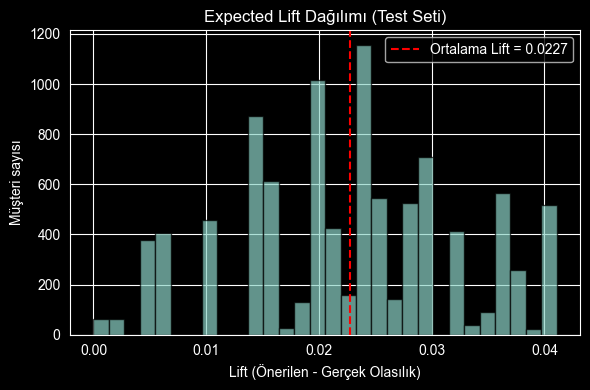

In [16]:
# Lift dağılımı
fig, ax = plt.subplots(figsize=(6, 4))
lift_df.loc[valid, "lift"].hist(bins=30, ax=ax, edgecolor="black", alpha=0.7)
ax.axvline(expected_lift, color="red", linestyle="--", label=f"Ortalama Lift = {expected_lift:.4f}")
ax.set_xlabel("Lift (Önerilen - Gerçek Olasılık)")
ax.set_ylabel("Müşteri sayısı")
ax.set_title("Expected Lift Dağılımı (Test Seti)")
ax.legend()
plt.tight_layout()
plt.show()